In [1]:
# Preparation
import numpy as np
np.set_printoptions(precision = 4, suppress = True)
import matplotlib.pyplot as plt
import ipywidgets

In [55]:
def mktr(x, y):
    return np.array([[1,0,x],
                     [0,1,y],
                     [0,0,1]])

def mkrot(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta),np.cos(theta),0],
                     [0,0,1]])

def drawf(f, ax = None, name = None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0,0,1],[1,0,1]]).T
    yhat = f @ np.array([[0,0,1],[0,1,1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0,:],xhat[1,:],'r-') # transformed x unit vector
    ax.plot(yhat[0,:],yhat[1,:],'g-') # transformed y unit vector
    if(name):
        ax.text(xhat[0,0],xhat[1,0],name,va="top",ha="center")
        
def drawrobot(f, l, ax = None, alpha = 0.5):
    """ Draw robot at f, with wheel distance l,
    on axis ax (if provided) or on plt.gca() otherwise """

    if(not ax):
        ax = plt.gca()
    
    robot = ([[-1, 2,-1,-1],  # x
              [-1, 0, 1,-1]]) # y 
    robot = np.array(robot)
    robot = np.vstack((
        robot * 0.1, # scale by 0.1 units
        np.ones((1,robot.shape[1]))))

    wheell = np.array([
        [-0.05,0.05],
        [l/2,l/2],
        [1,1]
    ])
    wheelr = wheell * np.array([[1,-1,1]]).T

    robott = f @ robot
    wheellt = f @ wheell
    wheelrt = f @ wheelr
    ax.plot(robott[0,:],robott[1,:],'k-',alpha=alpha)
    ax.plot(wheellt[0,:],wheellt[1,:],'k-',alpha=alpha)
    ax.plot(wheelrt[0,:],wheelrt[1,:],'k-',alpha=alpha)


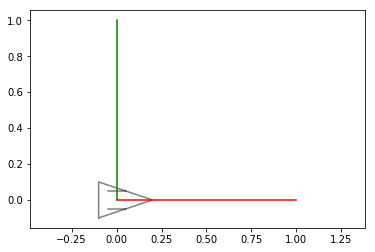

In [57]:
drawrobot(np.eye(3),0.1)
drawf(np.eye(3))
plt.gca().axis("equal");

In [56]:
vr = 0.10
vl = 0.05
l = 0.1
v_l = (vr+vl)/2
v_r = (vr-vl)/(2*l)
R = l * (vr + vl) / (vr - vl)

In [12]:
def ddtr(vl,vr,l,dt):
    omega = (vr-vl)/(2*l)
    if(np.isclose(omega,0)):
        return mktr((vr + vl)/2*dt,0)
    
    R = -1 * (l * (vr + vl) / (vr - vl))
    return  mktr(0,-R) @ mkrot(omega * dt) @ mktr(0,R)
    

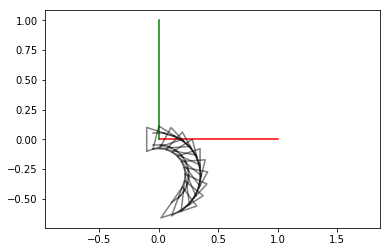

In [58]:
dt = 1.0
Ts = [np.eye(3)]

vl,vr = 0.10,0.05
for i in range(10):
    Ts.append(Ts[-1] @ ddtr(vl,vr,l,dt))

drawf(np.eye(3))
for T in Ts:
    drawrobot(T,l)
plt.axis("equal");

In [81]:
ipywidgets.Select?

In [61]:
@ipywidgets.interact(
    vl = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vr = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    l = ipywidgets.FloatSlider(min=0.05, max=0.15, value=0.10, step=0.01))
def f(vl,vr,l):
    Ts = [np.eye(3)]

    for i in range(10):
        Ts.append(Ts[-1] @ ddtr(vl,vr,l,1))

    drawf(np.eye(3))
    for T in Ts:
        drawrobot(T,l)
    plt.axis("equal");

interactive(children=(FloatSlider(value=0.0, description='vl', max=0.5, min=-0.5, step=0.02), FloatSlider(value=0.0, description='vr', max=0.5, min=-0.5, step=0.02), FloatSlider(value=0.1, description='l', max=0.15, min=0.05, step=0.01), Output()), _dom_classes=('widget-interact',))

In [98]:
l=0.1
@ipywidgets.interact(
    vl0 = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vr0 = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vl1 = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vr1 = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    dt = ipywidgets.Select(options=[1,5]))
def f(vl0,vr0,vl1,vr1,dt):
    l=0.1
    t0 = 0
    t1 = 10
    def wheelspeeds(t):
        return (vl0 + (vl1-vl0)*(t-t0)/(t1-t0),
                vr0 + (vr1-vr0)*(t-t0)/(t1-t0))
    
    ts = np.arange(t0,t1+dt,dt)
    vls,vrs = [],[]
    for t in ts:
        vl,vr = wheelspeeds(t)
        vls.append(vl)
        vrs.append(vr)
    
    cT = np.eye(3)
    Ts = []
    for i,t in enumerate(ts):
        if(i==0):
            Ts.append(cT)
        else:
            vl, vr = vls[i-1], vrs[i-1]
            cT = cT @ ddtr(vl,vr,l,dt)
            Ts.append(cT)

    fig,ax = plt.subplots()
    ax.plot(ts,vls,label=("left"))
    ax.plot(ts,vrs,label=("right"))
    ax.set(xlabel="time",
           ylabel="wheel tangential speed")
    ax.legend()
    
    fig,ax = plt.subplots()
    drawf(np.eye(3), ax=ax)
    for T in Ts:
        drawrobot(T,l,ax=ax)
    drawf(Ts[-1], name="time = {}".format(ts[-1]), ax=ax)
    plt.axis("equal");

interactive(children=(FloatSlider(value=0.0, description='vl0', max=0.5, min=-0.5, step=0.02), FloatSlider(value=0.0, description='vr0', max=0.5, min=-0.5, step=0.02), FloatSlider(value=0.0, description='vl1', max=0.5, min=-0.5, step=0.02), FloatSlider(value=0.0, description='vr1', max=0.5, min=-0.5, step=0.02), Select(description='dt', options=(1, 5), value=1), Output()), _dom_classes=('widget-interact',))